# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

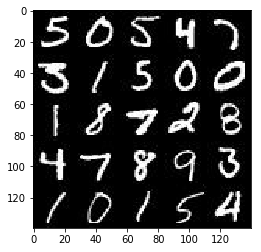

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

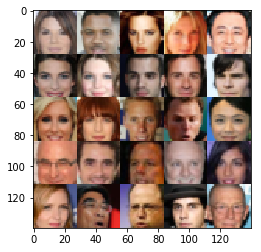

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, ([None, image_width, image_height, image_channels]), name='input_real')
    inputs_z = tf.placeholder(tf.float32, ([None, z_dim]), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [71]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # repurposed code from dcgan lesson
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.1

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
#     repurposed code from dcgan lesson
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # was 256, 5, 2
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        # was 128, 5, 2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, padding='same')
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    alpha = 0.1
    
    # repurposed code from dcgan lesson
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # repurpose code from dcgan lesson
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [84]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    _, image_width, image_height, out_channel_dim = data_shape
    
    input_real, input_z, lr = model_inputs(image_width = image_width, 
                                                      image_height = image_height, 
                                                      image_channels = out_channel_dim, 
                                                      z_dim = z_dim)
    
    d_loss, g_loss = model_loss(input_real = input_real, 
                                input_z = input_z, 
                                out_channel_dim = out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss = d_loss, 
                                         g_loss = g_loss, 
                                         learning_rate = learning_rate, 
                                         beta1 = beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    num_images = 25
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    # repurposed code from dcgan lesson
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr : learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images,
                                                     lr : learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images,
                                                lr : learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z,
                                                lr : learning_rate})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8238... Generator Loss: 0.3855
Epoch 1/2... Discriminator Loss: 1.5473... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 2.6685
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 0.5545... Generator Loss: 2.4000
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 1.4785
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 1.2180
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 2.2968
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.3864


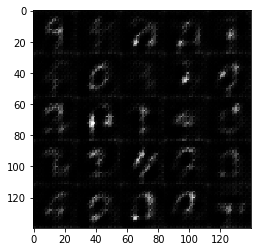

Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 1.5230
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.2270
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.5811
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 1.3316
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.4165


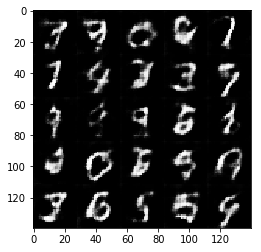

Epoch 1/2... Discriminator Loss: 2.0193... Generator Loss: 0.2098
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.8723
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 1.6702
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.6081
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.7397


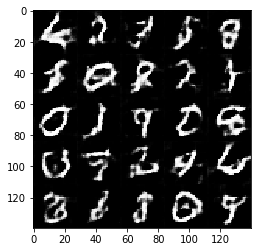

Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.3972
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.0036... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 1.5771
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 1.4110
Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 2.1122


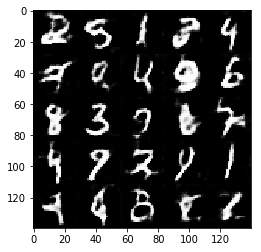

Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 0.7189
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.0601... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 2.8844... Generator Loss: 2.7387
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 1.1140
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.6129


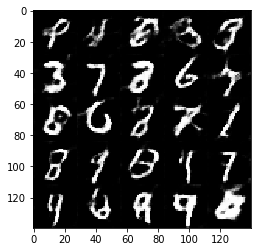

Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 1.6523
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.5517
Epoch 2/2... Discriminator Loss: 0.9718... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 1.1025... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 2.0923
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.0248


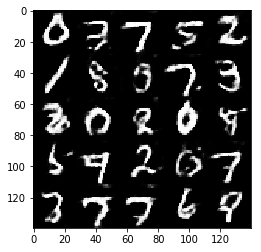

Epoch 2/2... Discriminator Loss: 1.4783... Generator Loss: 0.3618
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.0014... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.5732... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.6699
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 5.2286... Generator Loss: 5.6381


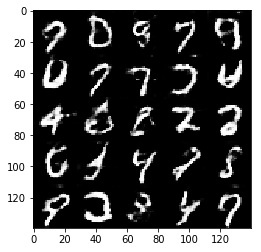

Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.4654
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.7008
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.5563
Epoch 2/2... Discriminator Loss: 2.1816... Generator Loss: 0.1693
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.4126


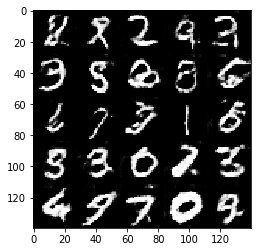

Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 0.4461
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.4297
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.6472
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.4264
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.8573
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 1.5874


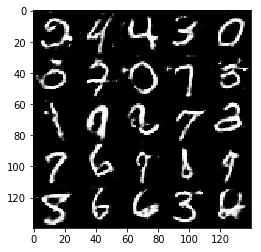

Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.2881


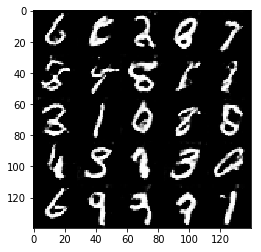

In [85]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 1.8094
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 0.2881... Generator Loss: 1.9418
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.4880
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 2.3032


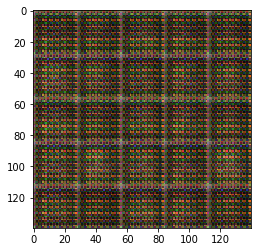

Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.8354
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.7132
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.0271


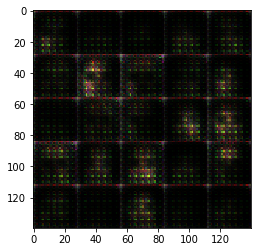

Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 2.1662
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6133


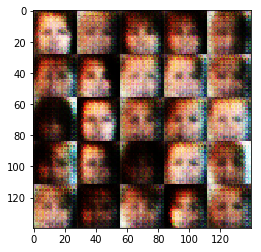

Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.4649
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.0233


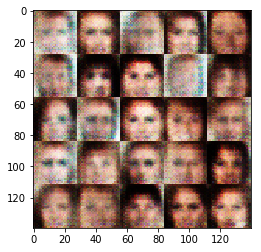

Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.2485
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.6995


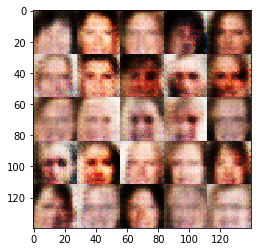

Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.2735


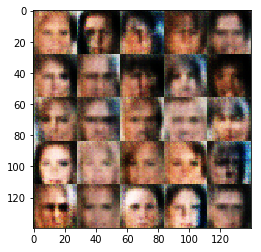

Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.8119


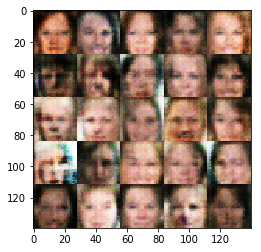

Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.3428


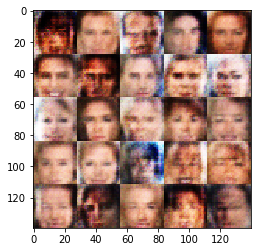

Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.3653
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.7823


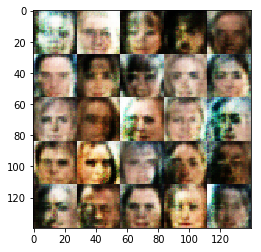

Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8452


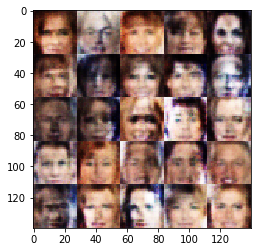

Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7869


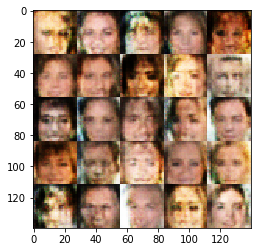

Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8652


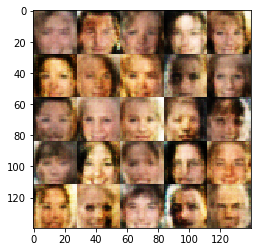

Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8526


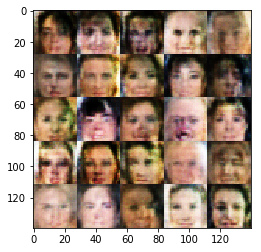

Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.8553


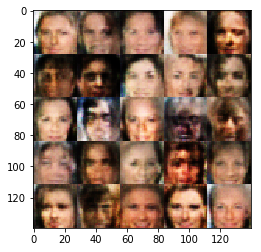

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7169


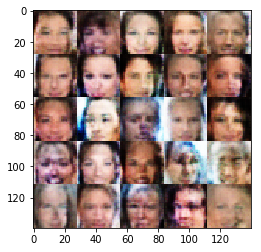

Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.7577


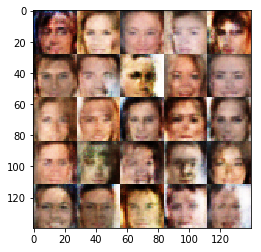

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.4820


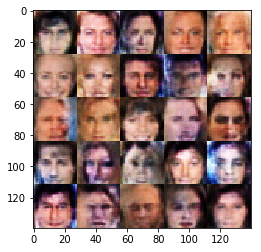

Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.7605


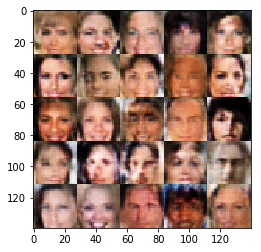

Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.7128


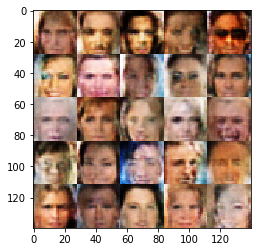

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6240


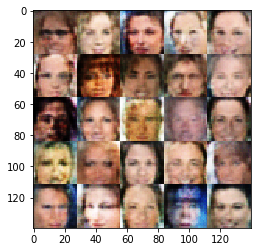

Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.5075


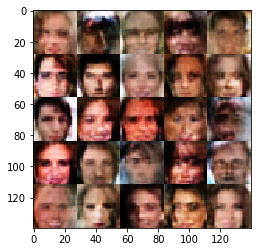

Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.7709


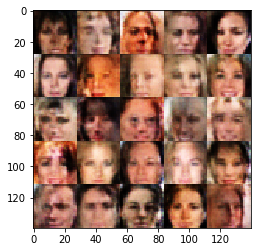

Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.3744


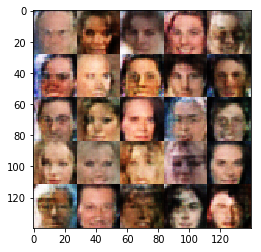

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.2763


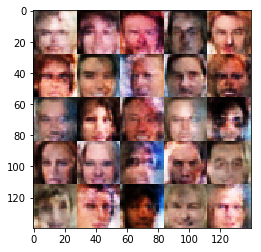

Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.8507


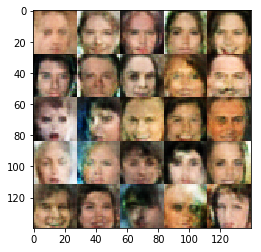

Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.8636


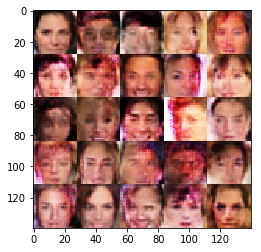

Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8477


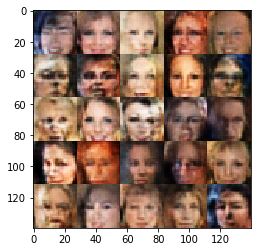

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.3911


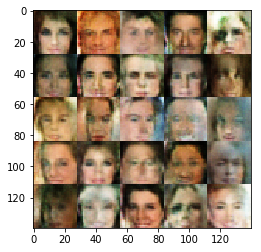

Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.7181


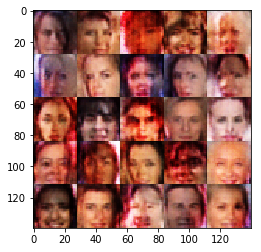

Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.4414
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.6116


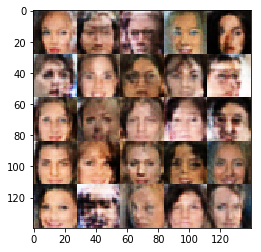

Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.5336


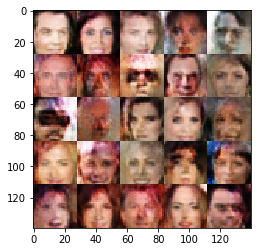

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5702


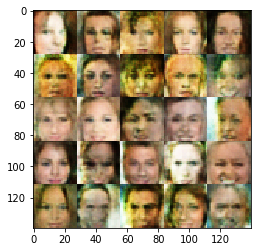

In [87]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.